## Configuration

### Imports

In [2]:
# Utilities
from IPython.display import display
import os
import numpy as np
import time
import pandas as pd
from fastprogress import master_bar, progress_bar

# MongoDB functionality
from pymongo import MongoClient, InsertOne, UpdateOne
from bson import ObjectId
from collections.abc import MutableMapping

# Graphics
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
sns.set_style({'font.family':'monospace'})
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Date Graphics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.dates import date2num


# Network analysis
import networkx as nx

ROOT_DIR = "/home/mattia/javier/botbusters-spanish-general-elections-network-analysis/"

# Change path to root
os.chdir(ROOT_DIR)

# MongoDB parameters
mongoclient = MongoClient('localhost', 27017)
db = mongoclient.influence

### Support Functions

In [3]:
def flatten(d, parent_key='', sep='_'):
    """Formats MongoDB results
    
    Keyword arguments:
    d -- dictionary with key and uncleaned values
    parent_key --
    sep --
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def make_objid(text):
    """Makes an ObjectId of 4 bytes
    
    Keyword arguments:
    text -- string to be converted into Object ID
    """
    text = str(text)
    if not text.strip():
        return None
    try:
        return ObjectId(text.rjust(24,"0"))
    except Exception as ex:
        print(text, ex)
        return None
    
def get_tweets(collection):
    """
    Gets tweets
    
    collection - Tweets MongoDB collection
    """
    tweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True, 'date':True})
                   )
    
    print("Number of tweets:", len(tweets))
    tweets = [flatten(t) for t in tweets]
    df_tweets = pd.DataFrame(tweets)
    df_tweets.user_id = df_tweets.user_id.apply(lambda t : str(t))
    df_tweets.user_id = df_tweets.user_id.astype(str)
    df_tweets.date = df_tweets.date.astype("datetime64")
    return df_tweets
    
    
def get_retweets(collection):
    """
    Gets retweets
    
    collection - Retweets MongoDB collection
    """
    retweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True, 'date':True})
                   )
    
    print("Number of retweets:", len(retweets))
    retweets = [flatten(r) for r in retweets]
    df_retweets = pd.DataFrame(retweets)
    df_retweets.user_id = df_retweets.user_id.apply(lambda t : str(t))
    df_retweets.user_id = df_retweets.user_id.astype(str)
    df_retweets.date = df_retweets.date.astype("datetime64")
    return df_retweets

def get_users(collection):
    """
    Gets users
    
    collection - Users MongoDB collection
    """
    users = list(collection.find({ '$and' : [ { 'sampled': True } , { 'botscore' : { '$gte' : 0 } }]},
                                 {'_id' : True, 'botscore' : True})
                )

    print("Number of sampled users with botscore in DB:", len(users))
    users = [flatten(u) for u in users]
    df_users = pd.DataFrame(users)
    df_users._id = df_users._id.apply(lambda t : str(t))
    df_users._id = df_users._id.astype(str)
    return df_users

def reindex_by_date(df):
    """Reindexes a DataFrame by date
    
    Keyword arguments:
    df -- DataFrame to be reindexed by date
    """
    dates = pd.date_range(xlim[0], xlim[1],name='created_at')
    return df.reindex(dates,fill_value=0)

def daterange(start_date, end_date):
    """Creates a generator of days to be used in loops
    
    Keyword arguments:
    start_date -- First date to be generated
    end_date -- Last date to be generated
    """
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

## Data preparation

#### Getting tweets from database

In [4]:
df_tweets = get_tweets(db.tweets)
df_tweets.head(3)

Number of tweets: 358190


,user_id,date,tweet_id
0,000000000000000279465279,2019-11-04 21:15:49,000001191464087064109058
1,000000000000001266667238,2019-11-08 12:53:41,000001192787272975945729
2,000000000000000331220696,2019-11-04 21:28:10,000001191467194519080960


In [5]:
df_tweets[df_tweets.duplicated()].count()
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358190 entries, 0 to 358189
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   358190 non-null  object        
 1   date      358190 non-null  datetime64[ns]
 2   tweet_id  358190 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 8.2+ MB


In [6]:
df_tweets.drop_duplicates(keep='first', inplace=True)

#### Getting retweets from database

In [7]:
df_retweets = get_retweets(db.retweets)
df_retweets.head(3)

Number of retweets: 7868861


,tweet_id,user_id,date
0,000001193667913368121351,000000000000004460826197,2019-11-10 23:15:43
1,000001192581634291355649,000001075150211725619200,2019-11-07 23:20:20
2,000001190659978471911424,000000000000000071190801,2019-11-02 16:54:42


In [8]:
df_retweets[df_retweets.duplicated()].count()

tweet_id    2
user_id     2
date        2
dtype: int64

In [9]:
df_retweets.drop_duplicates(keep='first', inplace=True)
df_retweets.count()

tweet_id    7868859
user_id     7868859
date        7868859
dtype: int64

#### Getting users from database

In [10]:
users = get_users(db.users)
display(users.head(5))
users_botscore = dict(zip(users._id, users.botscore))

Number of sampled users with botscore in DB: 1150709


,_id,botscore
0,000000000000002266588688,0.16
1,000000000000000471028961,0.03
2,000000000000002792368467,0.11
3,000000000000004068857357,0.01
4,000000000000000006953012,0.03


## 1. Number of interactions per day

#### Getting retweets + tweets, date and botscores

In [59]:
display(df_tweets.info())
display(df_retweets.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358190 entries, 0 to 358189
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   358190 non-null  object        
 1   date      358190 non-null  datetime64[ns]
 2   tweet_id  358190 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 10.9+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7868859 entries, 0 to 7868860
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   tweet_id  object        
 1   user_id   object        
 2   date      datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 240.1+ MB


None

In [60]:
df_traffic = df_tweets.append(df_retweets, ignore_index=True)
df_traffic['date'] = df_traffic.date.dt.date
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8227049 entries, 0 to 8227048
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   object
 1   date      object
 2   tweet_id  object
dtypes: object(3)
memory usage: 188.3+ MB


In [62]:
start = pd.to_datetime(pd.to_datetime('10/04/2019').strftime(format='%Y-%m-%d'))
end = pd.to_datetime(pd.to_datetime('11/11/2019').strftime(format='%Y-%m-%d'))
print(start, end)

2019-10-04 00:00:00 2019-11-11 00:00:00


In [63]:
# filter days
df_traffic = df_traffic[(df_traffic.date <= end) & (df_traffic.date >= start)]
xlim = (df_traffic.date.min(), df_traffic.date.max())
print(xlim)
df_traffic.head()

(datetime.date(2019, 10, 4), datetime.date(2019, 11, 11))


,user_id,date,tweet_id
0,000000000000000279465279,2019-11-04,000001191464087064109058
1,000000000000001266667238,2019-11-08,000001192787272975945729
2,000000000000000331220696,2019-11-04,000001191467194519080960
3,000000000000001452965868,2019-10-31,000001189959990624292868
4,000000978377302286401537,2019-10-11,000001182607615752396800


In [65]:
df_traffic['botscore'] = df_traffic.user_id.map(users_botscore)
df_traffic['botscore'] = df_traffic.botscore.round(decimals=1)
df_traffic.head()

,user_id,date,tweet_id,botscore
0,000000000000000279465279,2019-11-04,000001191464087064109058,0.0
1,000000000000001266667238,2019-11-08,000001192787272975945729,0.2
2,000000000000000331220696,2019-11-04,000001191467194519080960,0.1
3,000000000000001452965868,2019-10-31,000001189959990624292868,0.7
4,000000978377302286401537,2019-10-11,000001182607615752396800,NaN


In [66]:
df_traffic = df_traffic.dropna(axis='index', how='any').sort_values(by='date', ascending=True)

In [67]:
prs = [70,90]
ps = np.percentile(a=df_traffic.drop_duplicates(subset='user_id').botscore, q=prs, interpolation='lower')
print(ps)

[0.2 0.4]


In [68]:
def interval(row):
    if row['botscore'] < ps[0]:
        return 'Likely Humans'
    elif row['botscore'] < ps[1]:
        return 'Likely Semi-Bots'
    else:
        return 'Likely Bots'

In [69]:
df_traffic['Groups'] = df_traffic.apply(lambda row : interval(row), axis=1)
df_traffic.head()

,user_id,date,tweet_id,botscore,Groups
171101,000000000000002615419165,2019-10-04,000001180058636715995136,0.3,Likely Semi-Bots
1725656,000000000000000301536651,2019-10-04,000001180193426362585089,0.3,Likely Semi-Bots
1725658,000000000000000245728439,2019-10-04,000001180193426362585089,0.1,Likely Humans
1725659,000000908711303161708550,2019-10-04,000001180193426362585089,0.1,Likely Humans
1725660,000000000000000401296724,2019-10-04,000001180193426362585089,0.1,Likely Humans


In [328]:
df_traffic['kde_date'] = [x.toordinal() for x in df_traffic.date]
df_traffic.head()

,user_id,date,tweet_id,botscore,Groups,kde_date
171101,000000000000002615419165,2019-10-04,000001180058636715995136,0.3,Likely Semi-Bots,737336
1725656,000000000000000301536651,2019-10-04,000001180193426362585089,0.3,Likely Semi-Bots,737336
1725658,000000000000000245728439,2019-10-04,000001180193426362585089,0.1,Likely Humans,737336
1725659,000000908711303161708550,2019-10-04,000001180193426362585089,0.1,Likely Humans,737336
1725660,000000000000000401296724,2019-10-04,000001180193426362585089,0.1,Likely Humans,737336


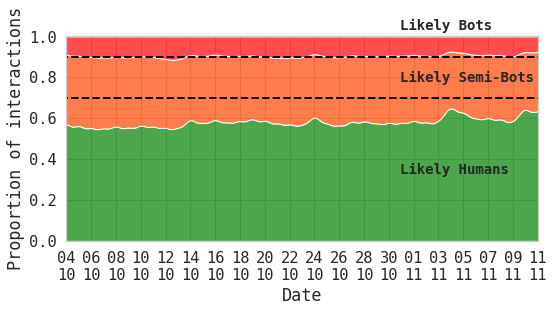

In [377]:
# plot
import datetime 


fig = plt.figure(figsize=(8,4.5))


ax = sns.kdeplot(data=df_traffic,
                x='kde_date', 
                hue='Groups',
                hue_order=['Likely Bots','Likely Semi-Bots', 'Likely Humans'],
                palette=['red','orangered','green'],
                multiple="fill",
                legend=False,
                alpha=0.7
                )


plt.xticks(np.arange(min(df_traffic.kde_date), max(df_traffic.kde_date)+1, 1))

x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%d\n%m') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)


plt.xlabel("Date")
plt.ylabel("Proportion of interactions")

"""ax.ax.xaxis.set_major_locator(mdates.DayLocator(interval=2)) #bymonthday=range(1,30,3)
hfmt = mdates.DateFormatter('%d\n%m')
ax.ax.xaxis.set_major_formatter(hfmt)
ax.ax.xaxis.set_tick_params(rotation=290)
"""

colors={prs[0]:'black',
        prs[1]:'black'}
h_xlims = ax.get_xlim()
for pr,p in zip(prs,ps):
    ax.hlines(y=pr/100, xmin=h_xlims[0], xmax=h_xlims[1], linewidth = 2, linestyles='dashed',color=colors[pr])

for position,label in zip([0.35,0.8,1.05],['Likely Humans', 'Likely Semi-Bots', 'Likely Bots']):
    text(y=position, x=h_xlims[1]-12.5, s= label, fontsize='small', fontweight='bold', verticalalignment='center')


plt.xlim(min(df_traffic.kde_date),max(df_traffic.kde_date))
plt.tight_layout()
plt.savefig("images/timeline-fill.svg", bbox_inches = "tight")
plt.savefig("images/timeline-fill.pdf", bbox_inches = "tight")

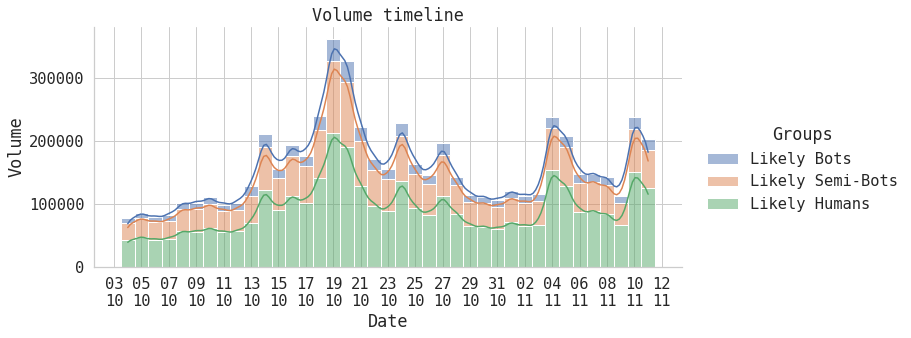

In [117]:
# plot
ax = sns.displot(data=df_traffic,
                   x='date', 
                   hue='Groups',
                hue_order=['Likely Bots','Likely Semi-Bots', 'Likely Humans'],
                  kde=True,
                   multiple="stack",
                  height=5,
                aspect=2)

plt.title('Volume timeline')
ax.set_axis_labels("Date", "Volume")
ax.ax.xaxis.set_major_locator(mdates.DayLocator(interval=2)) #bymonthday=range(1,30,3)
hfmt = mdates.DateFormatter('%d\n%m')
ax.ax.xaxis.set_major_formatter(hfmt)

ax.tight_layout()
ax.savefig("images/volume-timeline-stack.svg", bbox_inches = "tight")

#### Build directed-weighted retweet graph

In [118]:
df_retweets['botscore'] = df_retweets.user_id.map(users_botscore)
df_edges = df_retweets[['tweet_id','date','user_id','botscore']].rename({'user_id':'retweeter_id'}, axis='columns').set_index('tweet_id').join(df_tweets.rename({'user_id':'retweeted_id'}, axis='columns')[['tweet_id','retweeted_id']].set_index('tweet_id')).reset_index(drop=True)
df_edges.head(5)

,date,retweeter_id,botscore,retweeted_id
0,2019-05-03 19:58:27,000001041608534734061568,0.24,000000000000000068740712
1,2019-05-03 20:03:37,000000000000002824508322,0.08,000000000000000068740712
2,2019-05-03 20:30:39,000000755192640321314817,0.21,000000000000000068740712
3,2019-05-03 20:49:54,000000000000000523370717,NaN,000000000000000068740712
4,2019-05-03 20:54:27,000000000000003610966882,0.09,000000000000000068740712


## 2. Analysis of spreading cores

In [11]:
df_retweets['botscore'] = df_retweets.user_id.map(users_botscore)

df_edges = df_retweets[['tweet_id','date','user_id','botscore']].rename({'user_id':'retweeter_id'}, axis='columns').set_index('tweet_id').join(df_tweets.rename({'user_id':'retweeted_id'}, axis='columns')[['tweet_id','retweeted_id']].set_index('tweet_id')).reset_index(drop=True)
df_kcore = df_edges.groupby(['retweeter_id','retweeted_id']).size().reset_index().rename(columns={0:'weight'})

implicated_users = []
implicated_users = list(set(list(df_kcore.retweeter_id.unique()) + list(df_kcore.retweeted_id.unique())))
#print("Implicated users:", len(implicated_users))

df_users = users[users._id.isin(implicated_users)]
print("Users with botscore:", len(df_users))

print("Total retweets", len(df_kcore))
df_kcore = df_kcore[(df_kcore.retweeted_id.isin(df_users._id)) & (df_kcore.retweeter_id.isin(df_users._id))]
print("Retweets with botscore:", len(df_kcore))

Users with botscore: 1150709
Total retweets 6037031
Retweets with botscore: 4313219


In [12]:
G = nx.from_pandas_edgelist(df=df_kcore, source='retweeted_id', target='retweeter_id', edge_attr='weight', create_using=nx.DiGraph)

node_attr = df_users.set_index('_id').to_dict('index')
nx.set_node_attributes(G, node_attr)

In [13]:
#remove self loops for kshell
G.remove_edges_from(nx.selfloop_edges(G))

In [14]:
df_botscores = pd.DataFrame.from_records(list(G.nodes(data='botscore')), columns=['user','botscore'])
df_botscores.head(2)

,user,botscore
0,000000000000000026994875,0.06
1,000000000000000000002862,0.09


In [15]:
%%time
df_cores = pd.DataFrame(nx.core_number(G).items(), columns=['user','k-core'])
df_cores.head(2)

CPU times: user 7min 31s, sys: 469 ms, total: 7min 32s
Wall time: 7min 32s


,user,k-core
0,000000000000000026994875,17
1,000000000000000000002862,1


In [16]:
df_cores = df_cores.merge(df_botscores, on='user')
df_cores.sample(5)

,user,k-core,botscore
346767,000000000000000405271476,1,0.50
926726,000001061575310150418433,1,0.11
79650,000000000000000103307625,2,0.07
683995,000000000000003044583129,1,0.09
1005901,000001177579802339004417,1,0.44


In [22]:
df_cores.groupby('k-core').describe()

botscore                                                      
           count      mean       std   min    25%    50%     75%   max
k-core                                                                
0          192.0  0.233836  0.212009  0.00  0.060  0.160  0.3600  0.93
1       562977.0  0.161005  0.157731  0.00  0.040  0.110  0.2400  1.00
2       163507.0  0.145843  0.142762  0.00  0.040  0.100  0.2100  0.99
3        80219.0  0.141445  0.137213  0.00  0.040  0.100  0.2000  0.97
4        48079.0  0.141035  0.135839  0.00  0.040  0.100  0.2000  0.98
...          ...       ...       ...   ...    ...    ...     ...   ...
93         842.0  0.187253  0.151255  0.00  0.070  0.160  0.2600  0.82
94          22.0  0.133182  0.117611  0.01  0.055  0.095  0.1450  0.51
95          69.0  0.153816  0.129993  0.00  0.060  0.130  0.2200  0.78
96          42.0  0.132381  0.107381  0.00  0.060  0.105  0.1875  0.54
97         450.0  0.172347  0.146905  0.00  0.060  0.140  0.2500  0.89

[98 rows x 8 columns]

<AxesSubplot:ylabel='Frequency'>

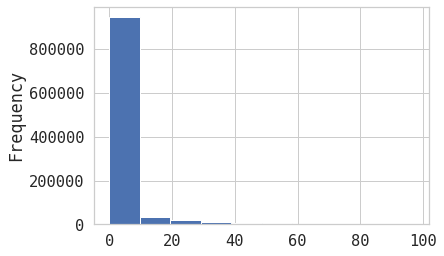

In [21]:
df_cores['k-core'].plot.hist()

In [ ]:
%%time
fig, axs = plt.subplots(1, 1, figsize=(8,5))

ax = sns.regplot(x='k-core',
            y='botscore',
            data=df_cores,
            x_bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
            scatter_kws = {'color': 'b', 's':12},
            line_kws = {'color': '#CCCC00'},
            order=9
           )

ax.set_ylabel(ylabel='Botscore')
ax.set_xlabel(xlabel='K')
#fig.suptitle("Composition of network k-cores", y=1.01)
plt.tight_layout()
plt.savefig("images/kcores.svg")
plt.savefig("images/kcores.pdf")

In [145]:
prs = [70,90]
ps = np.percentile(a=df_cores.drop_duplicates(subset='user').botscore, q=prs, interpolation='lower')
print(ps)

[0.19 0.37]


In [146]:
def interval(row):
    if row['botscore'] < ps[0]:
        return 'Likely Humans'
    elif row['botscore'] < ps[1]:
        return 'Likely Semi-Bots'
    else:
        return 'Likely Bots'

In [147]:
df_cores['Groups'] = df_cores.apply(lambda row : interval(row), axis=1)
df_cores.head()

,user,k-core,botscore,Groups
0,000000000000000026994875,17,0.06,Likely Humans
1,000000000000000000002862,1,0.09,Likely Humans
2,000000000000000014436030,93,0.01,Likely Humans
3,000000000000000000003968,1,0.05,Likely Humans
4,000000000000000035222818,22,0.24,Likely Semi-Bots


In [244]:
df_cores['k-core-bins'] = pd.cut(df_cores['k-core'], bins=30, labels=False)
df_cores.head()

,user,k-core,botscore,Groups,k-core-bins
0,000000000000000026994875,17,0.06,Likely Humans,5
1,000000000000000000002862,1,0.09,Likely Humans,0
2,000000000000000014436030,93,0.01,Likely Humans,28
3,000000000000000000003968,1,0.05,Likely Humans,0
4,000000000000000035222818,22,0.24,Likely Semi-Bots,6


In [280]:
df_cores['k-core'].max()

97

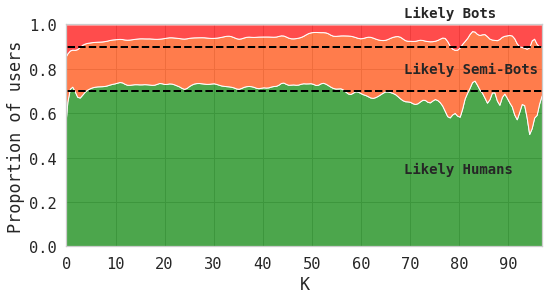

In [376]:
### %%time

fig = plt.figure(figsize=(8,4.5))

ax = sns.kdeplot(data=df_cores,
                x='k-core', 
                hue='Groups',
                hue_order=['Likely Bots','Likely Semi-Bots', 'Likely Humans'],
                palette=['red','orangered','green'],
                multiple="fill",
                legend=False,
                alpha=0.7
                )

#plt.title('Absolute composition of network k-core')
#ax.add_legend(loc='lower right')

#ax.set_axis_labels("K", "Proportion of users")

plt.xlabel("K")
plt.ylabel("Proportion of users")

colors={prs[0]:'black',
        prs[1]:'black'}

h_xlims = plt.gca().get_xlim()
for pr,p in zip(prs,ps):
    plt.hlines(y=pr/100, xmin=h_xlims[0], xmax=h_xlims[1], linewidth = 2, linestyles='dashed',color=colors[pr])
    #text(y=pr/100+0.01, x=h_xlims[1]+0.5, s= str(pr/100), verticalalignment='center')
    
for position,label in zip([0.35,0.8,1.05],['Likely Humans', 'Likely Semi-Bots', 'Likely Bots']):
    text(y=position, x=h_xlims[1]-30, s= label, fontsize='small', fontweight='bold', verticalalignment='center')

plt.xticks(np.arange(0,97,10))
plt.xlim(0,97)
plt.tight_layout()
plt.savefig('images/kcores-fill.svg', bbox_inches = "tight")
plt.savefig('images/kcores-fill.pdf', bbox_inches = "tight")

CPU times: user 5.25 s, sys: 316 ms, total: 5.57 s
Wall time: 1.21 s


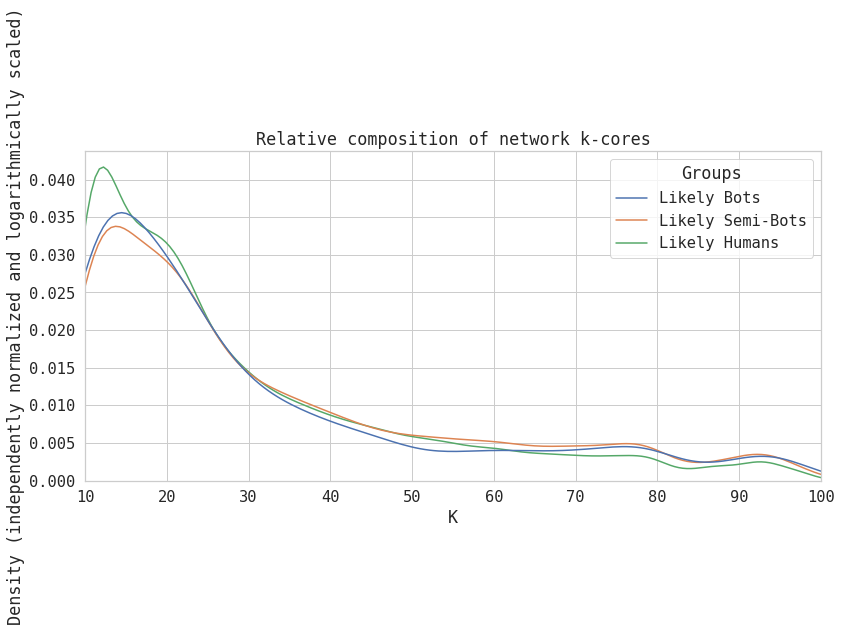

In [149]:
%%time

fig, axs = plt.subplots(1, 1, figsize=(12,6))

ax = sns.kdeplot(data=df_cores[df_cores['k-core']>=10],
                   x='k-core', 
                   hue='Groups',
                   common_norm=False,
                   #stat='probability',
                   #kde=True,
                hue_order=['Likely Bots','Likely Semi-Bots', 'Likely Humans'],
                log_scale=[False, False],
                   #multiple='stack',
                   #height=3,
                   #aspect=3,
                )

plt.title('Relative composition of network k-cores')
plt.xlim(10,100)
ax.set_xlabel("K")
ax.set_ylabel("Density (independently normalized and logarithmically scaled)")
plt.tight_layout()
plt.savefig('images/kcores-relative.svg', bbox_inches = "tight")